In [1]:
#!pip install yfinance
#import yfinance as yf
#!pip install mplfinance
#!pip install pytorch-
#!pip install pandas_ta
#! pip install statsforecast s3fs datasetsforecast
#!pip install git+https://github.com/Nixtla/neuralforecast.git@main

In [ ]:
import io
import os
import requests
import pandas as pd
import pandas_ta as ta
import numpy as np
from datetime import datetime, timedelta

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator
#import mplfinance as mpf
from statsforecast import StatsForecast

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed
from ray import tune

from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoNHITS, AutoLSTM
from neuralforecast.losses.pytorch import MQLoss

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate

from google.colab import drive, files

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Intermediate Forecasting: LSTM with Neural Forecast


Models envisioned:
- LSTM > ARIMA (2018): LSTM are better-suited for sequential data like financial time series since they can capture long-term dependencies and patterns in the data,


!!! Trading is more than price prediction: transaction cost, market liquidity, investor’s risk-aversion… These external factors make Reinforcement Learning more accurate than supervised learning for finance forecasting. RL is typically used in scenarios where an agent learns to interact with an environment to achieve a goal.

- RL+LSTM: building trading strategies and portfolio management
- DRL+LSTM (2022) provides portfolio scalability + market model independence
- LSTM+GARCH (2023) improves forecasting w/ volatility measures (crypto++)
- GARCH-EVT (Extreme Value Theory) is also powerful for high volatility.



To predict market tendencies based on financial data of multiple companies, I need:
- a Feature Matrix (X) containing the financial data of all companies
- a Target Vector (y) representing market tendencies


### N-HITS VS LSTM with NeuralForecast

https://nixtlaverse.nixtla.io/neuralforecast/examples/getting_started_complete.html

In [ ]:
# import dataset
files.upload()

In [ ]:
p2p20 = pd.read_csv('./p2p20 (1).csv')
p2p20.columns

Index(['index', 'company', 'date', 'open', 'high', 'low', 'close', 'adj close',
       'volume', 'return', 'market_tendency', 'signal', 'RSI', 'EMAF', 'EMAM',
       'EMAS', 'Target', 'TargetClass', 'TargetNextClose'],
      dtype='object')

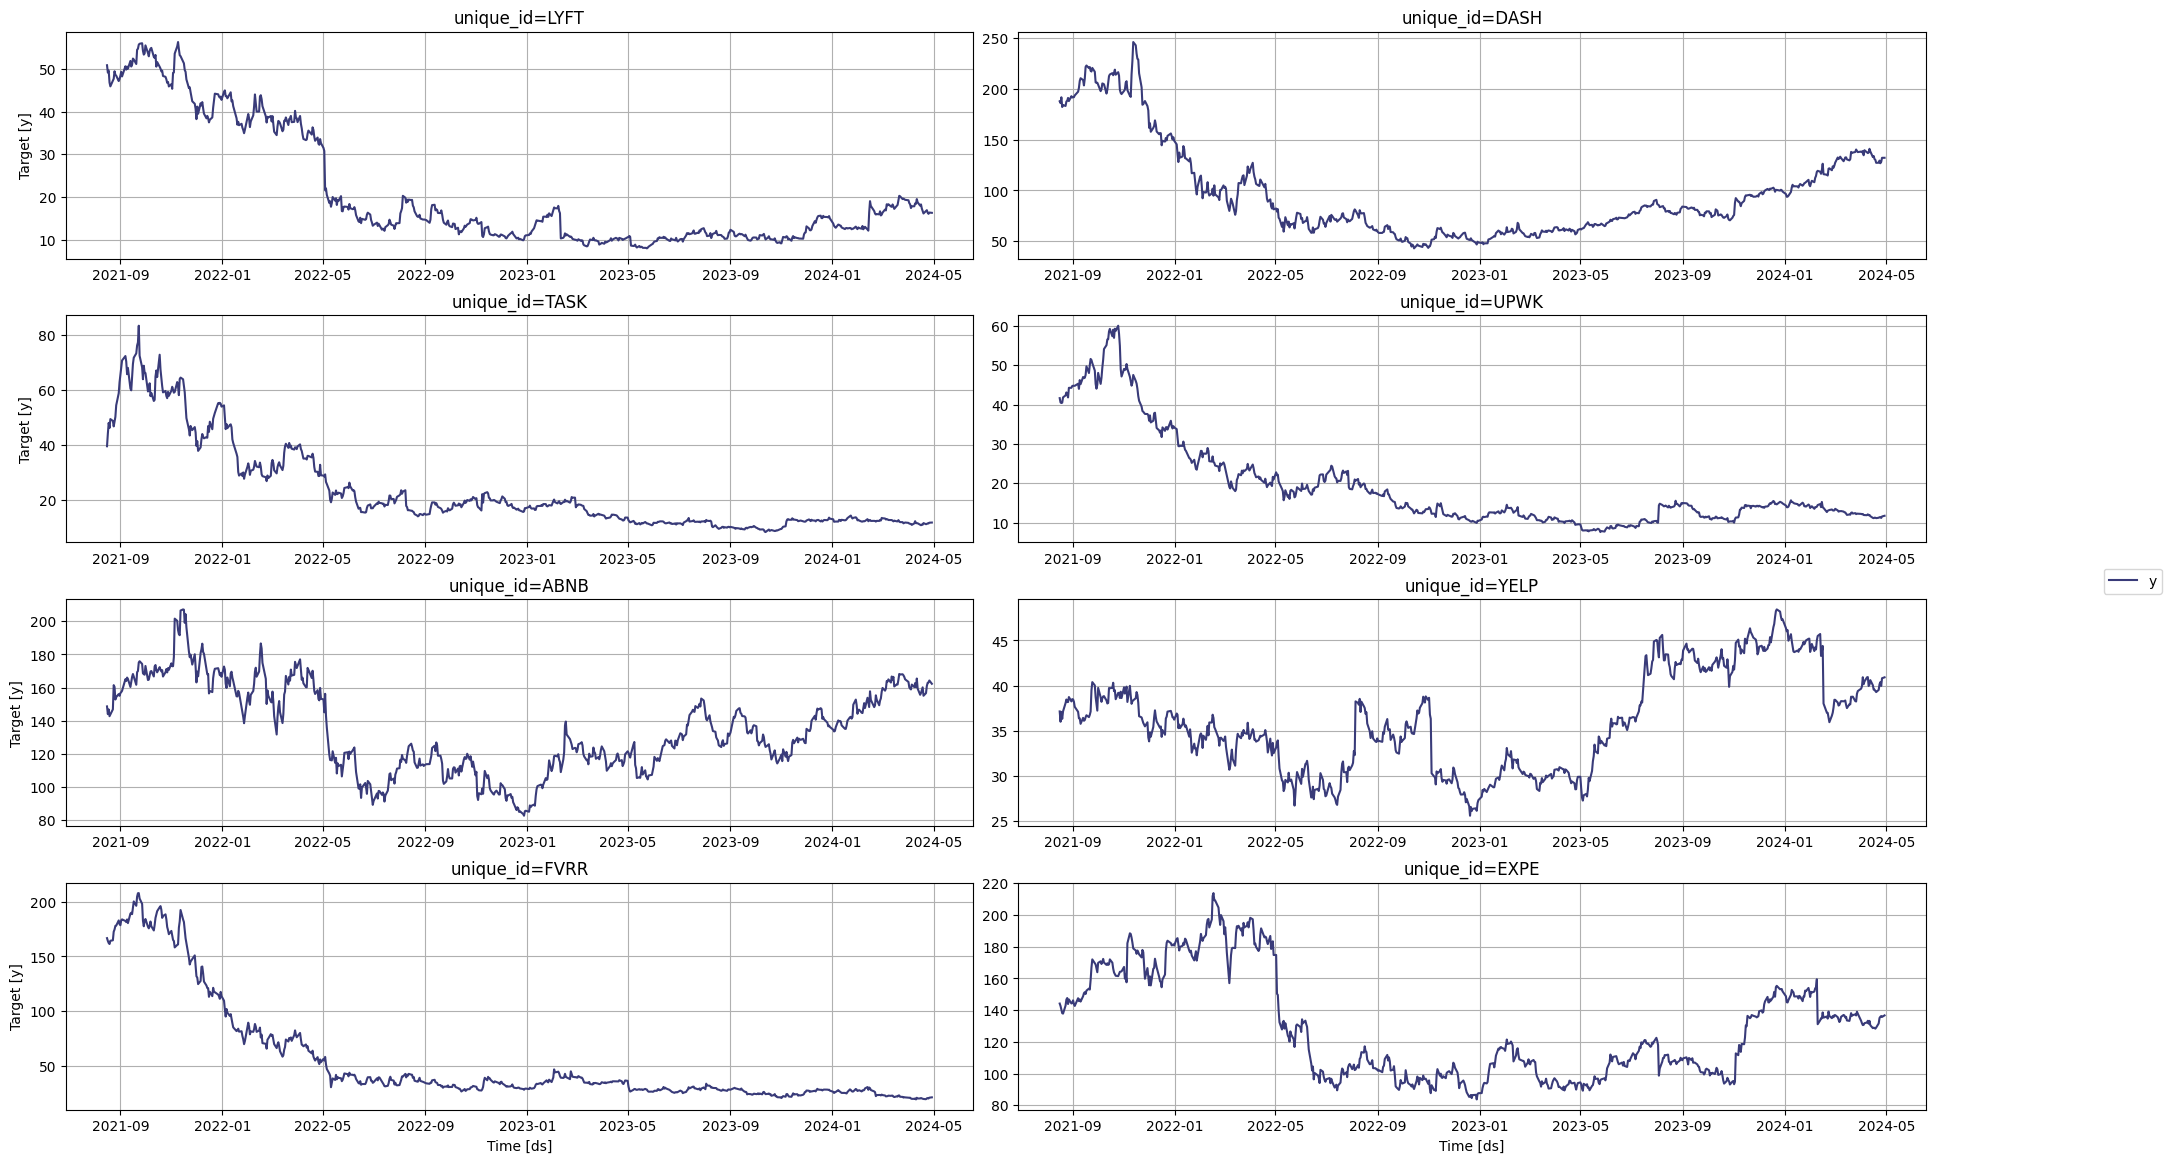

In [ ]:
# improved visualization with StatsForecast Library
uids = p2p20['company'].unique()[:10] # Select 10 ids to make the example faster
p2p20 = p2p20.query('company in @uids').reset_index(drop=True)
p2p20.rename(columns={'date': 'ds'}, inplace=True)
p2p20.rename(columns={'company': 'unique_id'}, inplace=True)
p2p20.rename(columns={'close': 'y'}, inplace=True)

StatsForecast.plot(p2p20, engine='matplotlib')

In [ ]:
# create NHITS and LSTM model with NeuralForecast
config_nhits = {
    "input_size": tune.choice([48, 48*2, 48*3]),              # Length of input window
    "start_padding_enabled": True,
    "n_blocks": 5*[1],                                              # Length of input window
    "mlp_units": 5 * [[64, 64]],                                  # Length of input window
    "n_pool_kernel_size": tune.choice([5*[1], 5*[2], 5*[4],
                                      [8, 4, 2, 1, 1]]),            # MaxPooling Kernel size
    "n_freq_downsample": tune.choice([[8, 4, 2, 1, 1],
                                      [1, 1, 1, 1, 1]]),            # Interpolation expressivity ratios
    "learning_rate": tune.loguniform(1e-4, 1e-2),                   # Initial Learning rate
    "scaler_type": tune.choice([None]),                             # Scaler type
    "max_steps": tune.choice([1000]),                               # Max number of training iterations
    "batch_size": tune.choice([1, 4, 10]),                          # Number of series in batch
    "windows_batch_size": tune.choice([128, 256, 512]),             # Number of windows in batch
    "random_seed": tune.randint(1, 20),                             # Random seed
}

config_lstm = {
    "input_size": tune.choice([48, 48*2, 48*3]),              # Length of input window
    "encoder_hidden_size": tune.choice([64, 128]),            # Hidden size of LSTM cells
    "encoder_n_layers": tune.choice([2,4]),                   # Number of layers in LSTM
    "learning_rate": tune.loguniform(1e-4, 1e-2),             # Initial Learning rate
    "scaler_type": tune.choice(['robust']),                   # Scaler type
    "max_steps": tune.choice([500, 1000]),                    # Max number of training iterations
    "batch_size": tune.choice([1, 4]),                        # Number of series in batch
    "random_seed": tune.randint(1, 20),                       # Random seed
}

In [ ]:
nf = NeuralForecast(
    models=[
        AutoNHITS(h=48, config=config_nhits, loss=MQLoss(), num_samples=5),
        AutoLSTM(h=48, config=config_lstm, loss=MQLoss(), num_samples=2),
    ],
    freq=1
)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: UserWarning:

Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.



In [ ]:
# fit the models
p2p20['ds'] = p2p20['ds'].astype(int)
p2p20=p2p20.drop(columns=['signal'])
nf.fit(df=p2p20)

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

2024-05-16 14:54:56,656	INFO worker.py:1749 -- Started a local Ray instance.
2024-05-16 14:54:58,424	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `Tuner(...)`.


+--------------------------------------------------------------------+
| Configuration for experiment     _train_tune_2024-05-16_14-54-52   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 5                                 |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/_train_tune_2024-05-16_14-54-52
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-05-16_14-54-52_897331_354/artifacts/2024-05-16_14-54-58/_train_tune_2024-05-16_14-54-52/driver_artifacts`


(_train_tune pid=6379) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=6379) Seed set to 10
(_train_tune pid=6379) GPU available: False, used: False
(_train_tune pid=6379) TPU available: False, using: 0 TPU cores
(_train_tune pid=6379) IPU available: False, using: 0 IPUs
(_train_tune pid=6379) HPU available: False, using: 0 HPUs
(_train_tune pid=6379) Missing logger folder: /tmp/ray/session_2024-05-16_14-54-52_897331_354/artifacts/2024-05-16_14-54-58/_train_tune_2024-05-16_14-54-52/working_dirs/_train_tune_b23c7_00000_0_batch_size=1,input_size=48,learning_rate=0.0004,max_steps=1000,n_freq_downsample=1_1_1_1_1,n_pool_kernel_2024-05-16_14-54-58/lightning_logs
(_train_tune pid=6379) 2024-05-16 14:55:10.282763: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unabl

Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 34.66it/s, v_num=0, train_loss_step=0.813, train_loss_epoch=1.700]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  80%|████████  | 8/10 [00:00<00:00, 197.05it/s]
(_train_tune pid=6379) 
Epoch 19: 100%|██████████| 10/10 [00:00<00:00, 51.64it/s, v_num=0, train_loss_step=0.808, train_loss_epoch=1.680, valid_loss=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/10 [00:00<?, ?it/s]
(_train_tune pid=6379) 
Epoch 29: 100%|██████████| 10/10 [00:00<00:00, 54.80it/s, v_num=0, train_loss_step=0.702, train_loss_epoch=1.740, valid_loss=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  10%|█         | 1/10 [00:00<00:00, 326.96it/s]
(_train_tune pid=6379) 
Validation DataLoader 0:  20%|██        | 2/10 [00:00<00:00, 227.44it/s]
(_train_tune pid=6379) 
Validation DataLoader 0:  30%|███       | 3/10 [00:00<00:00, 212.59it/s]
(_train_tune pid=6379) 
Validatio

(_train_tune pid=6379) `Trainer.fit` stopped: `max_steps=1000` reached.
(_train_tune pid=6626) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=6626) Seed set to 11
(_train_tune pid=6626) GPU available: False, used: False
(_train_tune pid=6626) TPU available: False, using: 0 TPU cores
(_train_tune pid=6626) IPU available: False, using: 0 IPUs
(_train_tune pid=6626) HPU available: False, using: 0 HPUs
(_train_tune pid=6626) Missing logger folder: /tmp/ray/session_2024-05-16_14-54-52_897331_354/artifacts/2024-05-16_14-54-58/_train_tune_2024-05-16_14-54-52/working_dirs/_train_tune_b23c7_00001_1_batch_size=4,input_size=144,learning_rate=0.0003,max_steps=1000,n_freq_downsample=8_4_2_1_1,n_pool_kerne_2024-05-16_14-54-58/lightning_logs
(_train_tune pid=6626) 2024-05-16 14:55:51.30941

Epoch 33:  33%|███▎      | 1/3 [00:00<00:00, 25.32it/s, v_num=0, train_loss_step=1.400, train_loss_epoch=2.050]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 66:  67%|██████▋   | 2/3 [00:00<00:00, 15.24it/s, v_num=0, train_loss_step=1.590, train_loss_epoch=1.610, valid_loss=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 27.65it/s, v_num=0, train_loss_step=0.649, train_loss_epoch=1.430, valid_loss=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 133:  33%|███▎      | 1/3 [00:00<00:00, 25.41it/s, v_num=0, train_loss_step=1.700, train_loss_epoch=1.710, valid_loss=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 166:  67%|██████▋   | 2/3 [00:00<00:00, 18.28it/s, v_num=0, train_loss_step=0.725, train_loss_epoch=1.510, valid_loss=1.130]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 3/3 [00:00<00:00, 26.16it/s, v_num=0, train_loss_step=1.120, train_loss_epoch=1.440, valid_loss=1.150]
Valid

(_train_tune pid=6626) `Trainer.fit` stopped: `max_steps=1000` reached.
(_train_tune pid=6945) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=6945) Seed set to 15
(_train_tune pid=6945) GPU available: False, used: False
(_train_tune pid=6945) TPU available: False, using: 0 TPU cores
(_train_tune pid=6945) IPU available: False, using: 0 IPUs
(_train_tune pid=6945) HPU available: False, using: 0 HPUs
(_train_tune pid=6945) Missing logger folder: /tmp/ray/session_2024-05-16_14-54-52_897331_354/artifacts/2024-05-16_14-54-58/_train_tune_2024-05-16_14-54-52/working_dirs/_train_tune_b23c7_00002_2_batch_size=4,input_size=96,learning_rate=0.0001,max_steps=1000,n_freq_downsample=8_4_2_1_1,n_pool_kernel_2024-05-16_14-54-58/lightning_logs
(_train_tune pid=6945) 2024-05-16 14:56:52.23217

Epoch 33:  33%|███▎      | 1/3 [00:00<00:00, 24.94it/s, v_num=0, train_loss_step=1.950, train_loss_epoch=1.500]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 66:  67%|██████▋   | 2/3 [00:00<00:00, 30.72it/s, v_num=0, train_loss_step=1.610, train_loss_epoch=1.750, valid_loss=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  33%|███▎      | 1/3 [00:00<00:00, 312.12it/s]
(_train_tune pid=6945) 
Validation DataLoader 0:  67%|██████▋   | 2/3 [00:00<00:00, 225.51it/s]
(_train_tune pid=6945) 
Validation DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 199.31it/s]
(_train_tune pid=6945) 
Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 13.97it/s, v_num=0, train_loss_step=3.130, train_loss_epoch=1.610, valid_loss=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/3 [00:00<?, ?it/s]
(_train_tune pid=6945) 
Epoch 133:  33%|███▎      | 1/3 [00:00<00:00,  9.84it/s, v_num=0, train_loss_step=1.760, train_loss_epoch=1.440, va

(_train_tune pid=6945) `Trainer.fit` stopped: `max_steps=1000` reached.
(_train_tune pid=7310) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=7310) Seed set to 8
(_train_tune pid=7310) GPU available: False, used: False
(_train_tune pid=7310) TPU available: False, using: 0 TPU cores
(_train_tune pid=7310) IPU available: False, using: 0 IPUs
(_train_tune pid=7310) HPU available: False, using: 0 HPUs
(_train_tune pid=7310) Missing logger folder: /tmp/ray/session_2024-05-16_14-54-52_897331_354/artifacts/2024-05-16_14-54-58/_train_tune_2024-05-16_14-54-52/working_dirs/_train_tune_b23c7_00003_3_batch_size=1,input_size=96,learning_rate=0.0010,max_steps=1000,n_freq_downsample=8_4_2_1_1,n_pool_kernel_2024-05-16_14-54-58/lightning_logs
(_train_tune pid=7310) 2024-05-16 14:58:04.787241

Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 33.68it/s, v_num=0, train_loss_step=0.767, train_loss_epoch=1.690]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 10/10 [00:00<00:00, 32.46it/s, v_num=0, train_loss_step=1.150, train_loss_epoch=1.690, valid_loss=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 29: 100%|██████████| 10/10 [00:00<00:00, 33.63it/s, v_num=0, train_loss_step=0.749, train_loss_epoch=1.610, valid_loss=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 39: 100%|██████████| 10/10 [00:00<00:00, 24.54it/s, v_num=0, train_loss_step=1.130, train_loss_epoch=1.640, valid_loss=1.160]
(_train_tune pid=7310) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 49: 100%|██████████| 10/10 [00:00<00:00, 32.06it/s, v_num=0, train_loss_step=1.710, train_loss_epoch=1.580, valid_loss=1.140]
(_train_tune pid=7310) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 59: 100%|██████████| 10/10 [00:00<00:00, 30.83it/s, v_num=0, train_loss_ste

(_train_tune pid=7310) `Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 29.75it/s, v_num=0, train_loss_step=2.400, train_loss_epoch=1.520, valid_loss=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 26.15it/s, v_num=0, train_loss_step=2.400, train_loss_epoch=1.540, valid_loss=1.250]


(_train_tune pid=7574) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=7574) Seed set to 17
(_train_tune pid=7574) GPU available: False, used: False
(_train_tune pid=7574) TPU available: False, using: 0 TPU cores
(_train_tune pid=7574) IPU available: False, using: 0 IPUs
(_train_tune pid=7574) HPU available: False, using: 0 HPUs
(_train_tune pid=7574) Missing logger folder: /tmp/ray/session_2024-05-16_14-54-52_897331_354/artifacts/2024-05-16_14-54-58/_train_tune_2024-05-16_14-54-52/working_dirs/_train_tune_b23c7_00004_4_batch_size=4,input_size=144,learning_rate=0.0031,max_steps=1000,n_freq_downsample=8_4_2_1_1,n_pool_kerne_2024-05-16_14-54-58/lightning_logs
(_train_tune pid=7574) 2024-05-16 14:58:54.796863: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unabl

Epoch 33:  33%|███▎      | 1/3 [00:00<00:00,  6.74it/s, v_num=0, train_loss_step=0.819, train_loss_epoch=1.490]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 66:  67%|██████▋   | 2/3 [00:00<00:00,  9.95it/s, v_num=0, train_loss_step=1.160, train_loss_epoch=1.650, valid_loss=1.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 248.47it/s]
(_train_tune pid=7574) 
Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 11.10it/s, v_num=0, train_loss_step=1.960, train_loss_epoch=1.510, valid_loss=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 133:  33%|███▎      | 1/3 [00:00<00:00,  6.78it/s, v_num=0, train_loss_step=1.340, train_loss_epoch=1.370, valid_loss=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 166:  67%|██████▋   | 2/3 [00:00<00:00, 10.30it/s, v_num=0, train_loss_step=0.803, train_loss_epoch=1.310, valid_loss=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████

2024-05-16 15:00:46,867	INFO tune.py:1007 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/_train_tune_2024-05-16_14-54-52' in 0.0104s.


Epoch 333:   0%|          | 0/3 [00:00<?, ?it/s, v_num=0, train_loss_step=0.838, train_loss_epoch=1.100, valid_loss=1.860]


(_train_tune pid=7574) `Trainer.fit` stopped: `max_steps=1000` reached.
INFO:lightning_fabric.utilities.seed:Seed set to 11


Epoch 333:  33%|███▎      | 1/3 [00:00<00:00,  9.72it/s, v_num=0, train_loss_step=1.040, train_loss_epoch=1.100, valid_loss=1.860]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 333:  33%|███▎      | 1/3 [00:00<00:00,  7.81it/s, v_num=0, train_loss_step=1.040, train_loss_epoch=1.040, valid_loss=1.720]



INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MQLoss        | 5     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 118 K 
-----------------------------------------------
118 K     Trainable params
5         Non-trainable params
118 K     Total params
0.473     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


+--------------------------------------------------------------------+
| Configuration for experiment     _train_tune_2024-05-16_15-02-31   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 2                                 |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/_train_tune_2024-05-16_15-02-31
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-05-16_14-54-52_897331_354/artifacts/2024-05-16_15-02-31/_train_tune_2024-05-16_15-02-31/driver_artifacts`


(_train_tune pid=8550) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=8550) Seed set to 13
(_train_tune pid=8550) GPU available: False, used: False
(_train_tune pid=8550) TPU available: False, using: 0 TPU cores
(_train_tune pid=8550) IPU available: False, using: 0 IPUs
(_train_tune pid=8550) HPU available: False, using: 0 HPUs
(_train_tune pid=8550) Missing logger folder: /tmp/ray/session_2024-05-16_14-54-52_897331_354/artifacts/2024-05-16_15-02-31/_train_tune_2024-05-16_15-02-31/working_dirs/_train_tune_b23c0_00000_0_batch_size=1,encoder_hidden_size=128,encoder_n_layers=2,input_size=48,learning_rate=0.0006,max_steps=500_2024-05-16_15-02-31/lightning_logs
(_train_tune pid=8550) 2024-05-16 15:02:42.651666: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 57.54it/s, v_num=0, train_loss_step=0.250, train_loss_epoch=0.266]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  10%|█         | 1/10 [00:00<00:00, 15.97it/s]
(_train_tune pid=8550) 
Validation DataLoader 0:  30%|███       | 3/10 [00:00<00:00, 16.70it/s]
(_train_tune pid=8550) 
Validation DataLoader 0:  50%|█████     | 5/10 [00:00<00:00, 16.69it/s]
(_train_tune pid=8550) 
Validation DataLoader 0:  60%|██████    | 6/10 [00:00<00:00, 16.75it/s]
(_train_tune pid=8550) 
Validation DataLoader 0:  70%|███████   | 7/10 [00:00<00:00, 16.83it/s]
(_train_tune pid=8550) 
Validation DataLoader 0:  80%|████████  | 8/10 [00:00<00:00, 16.77it/s]
(_train_tune pid=8550) 
Validation DataLoader 0:  90%|█████████ | 9/10 [00:00<00:00, 16.90it/s]
(_train_tune pid=8550) 
Epoch 19: 100%|██████████| 10/10 [00:00<00:00, 62.21it/s, v_num=0, train_loss_step=0.223, train_loss_epoch=0.244, vali

(_train_tune pid=8550) `Trainer.fit` stopped: `max_steps=500` reached.


(_train_tune pid=8550) 
Epoch 49: 100%|██████████| 10/10 [00:00<00:00, 15.09it/s, v_num=0, train_loss_step=0.155, train_loss_epoch=0.217, valid_loss=1.440]


(_train_tune pid=8724) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=8724) Seed set to 2
(_train_tune pid=8724) GPU available: False, used: False
(_train_tune pid=8724) TPU available: False, using: 0 TPU cores
(_train_tune pid=8724) IPU available: False, using: 0 IPUs
(_train_tune pid=8724) HPU available: False, using: 0 HPUs
(_train_tune pid=8724) Missing logger folder: /tmp/ray/session_2024-05-16_14-54-52_897331_354/artifacts/2024-05-16_15-02-31/_train_tune_2024-05-16_15-02-31/working_dirs/_train_tune_b23c0_00001_1_batch_size=4,encoder_hidden_size=128,encoder_n_layers=2,input_size=48,learning_rate=0.0002,max_steps=100_2024-05-16_15-02-31/lightning_logs
(_train_tune pid=8724) 2024-05-16 15:03:09.088566: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable

Epoch 33:  33%|███▎      | 1/3 [00:00<00:00, 28.11it/s, v_num=0, train_loss_step=0.249, train_loss_epoch=0.172]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/3 [00:00<?, ?it/s]
(_train_tune pid=8724) 
Validation DataLoader 0:  33%|███▎      | 1/3 [00:00<00:00,  3.87it/s]
(_train_tune pid=8724) 
Validation DataLoader 0:  67%|██████▋   | 2/3 [00:00<00:00,  4.01it/s]
(_train_tune pid=8724) 
Epoch 66:  67%|██████▋   | 2/3 [00:00<00:00, 18.94it/s, v_num=0, train_loss_step=0.252, train_loss_epoch=0.644, valid_loss=4.960]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/3 [00:00<?, ?it/s]
(_train_tune pid=8724) 
Validation DataLoader 0:  33%|███▎      | 1/3 [00:00<00:00,  2.91it/s]
(_train_tune pid=8724) 
Validation DataLoader 0:  67%|██████▋   | 2/3 [00:00<00:00,  2.78it/s]
(_train_tune pid=8724) 
Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 34.48it/s, v_num=0, train_loss_step=3.620, train_loss_epoch=0.186, 

2024-05-16 15:04:23,596	WARNING experiment_state.py:205 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this error by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0).
2024-05-16 15:04:23,606	INFO tune.py:1007 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/_train_tune_2024-05-16_15-02-31' in 0.0189s.


(_train_tune pid=8724) 
Validation DataLoader 0:  67%|██████▋   | 2/3 [00:01<00:00,  1.19it/s]



(_train_tune pid=8724) `Trainer.fit` stopped: `max_steps=1000` reached.
INFO:lightning_fabric.utilities.seed:Seed set to 2
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type          | Params
--------------------------------------------------
0 | loss            | MQLoss        | 5     
1 | padder          | ConstantPad1d | 0     
2 | scaler          | TemporalNorm  | 0     
3 | hist_encoder    | LSTM          | 199 K 
4 | context_adapter | Linear        | 61.9 K
5 | mlp_decoder     | MLP           | 3.2 K 
--------------------------------------------------
264 K     Trainable params
5         Non-trainable params
264 K     Total params
1.057     To

(_train_tune pid=8724) 
Epoch 333:  33%|███▎      | 1/3 [00:01<00:03,  0.50it/s, v_num=0, train_loss_step=0.199, train_loss_epoch=0.199, valid_loss=1.300]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


In [ ]:
# predict
fcst_df = nf.predict()
fcst_df.columns = fcst_df.columns.str.replace('-median', '')
fcst_df.head()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:196: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.



,ds,AutoNHITS,AutoNHITS-lo-90,AutoNHITS-lo-80,AutoNHITS-hi-80,AutoNHITS-hi-90,AutoLSTM,AutoLSTM-lo-90,AutoLSTM-lo-80,AutoLSTM-hi-80,AutoLSTM-hi-90
unique_id,,,,,,,,,,,
ABNB,1714348800000000001,162.467392,155.330383,157.556717,167.599884,170.050293,162.519852,145.334625,149.505753,173.763474,180.779099
ABNB,1714348800000000002,162.298462,153.957184,156.782257,168.799805,171.410721,162.470947,144.176910,148.919708,172.768478,181.021973
ABNB,1714348800000000003,162.431473,151.035828,154.575333,171.025711,174.460052,161.907654,140.987564,146.957977,175.423401,183.625961
ABNB,1714348800000000004,162.526840,149.262314,153.206055,172.902618,177.200790,161.701126,136.974228,144.418533,176.037018,186.240753
ABNB,1714348800000000005,162.130753,148.511948,152.935593,174.461395,178.779388,161.105804,139.372070,145.474426,174.485123,182.066467


/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:1329: FutureWarning:

Passing the ids as the index is deprecated. Please provide them as a column instead.



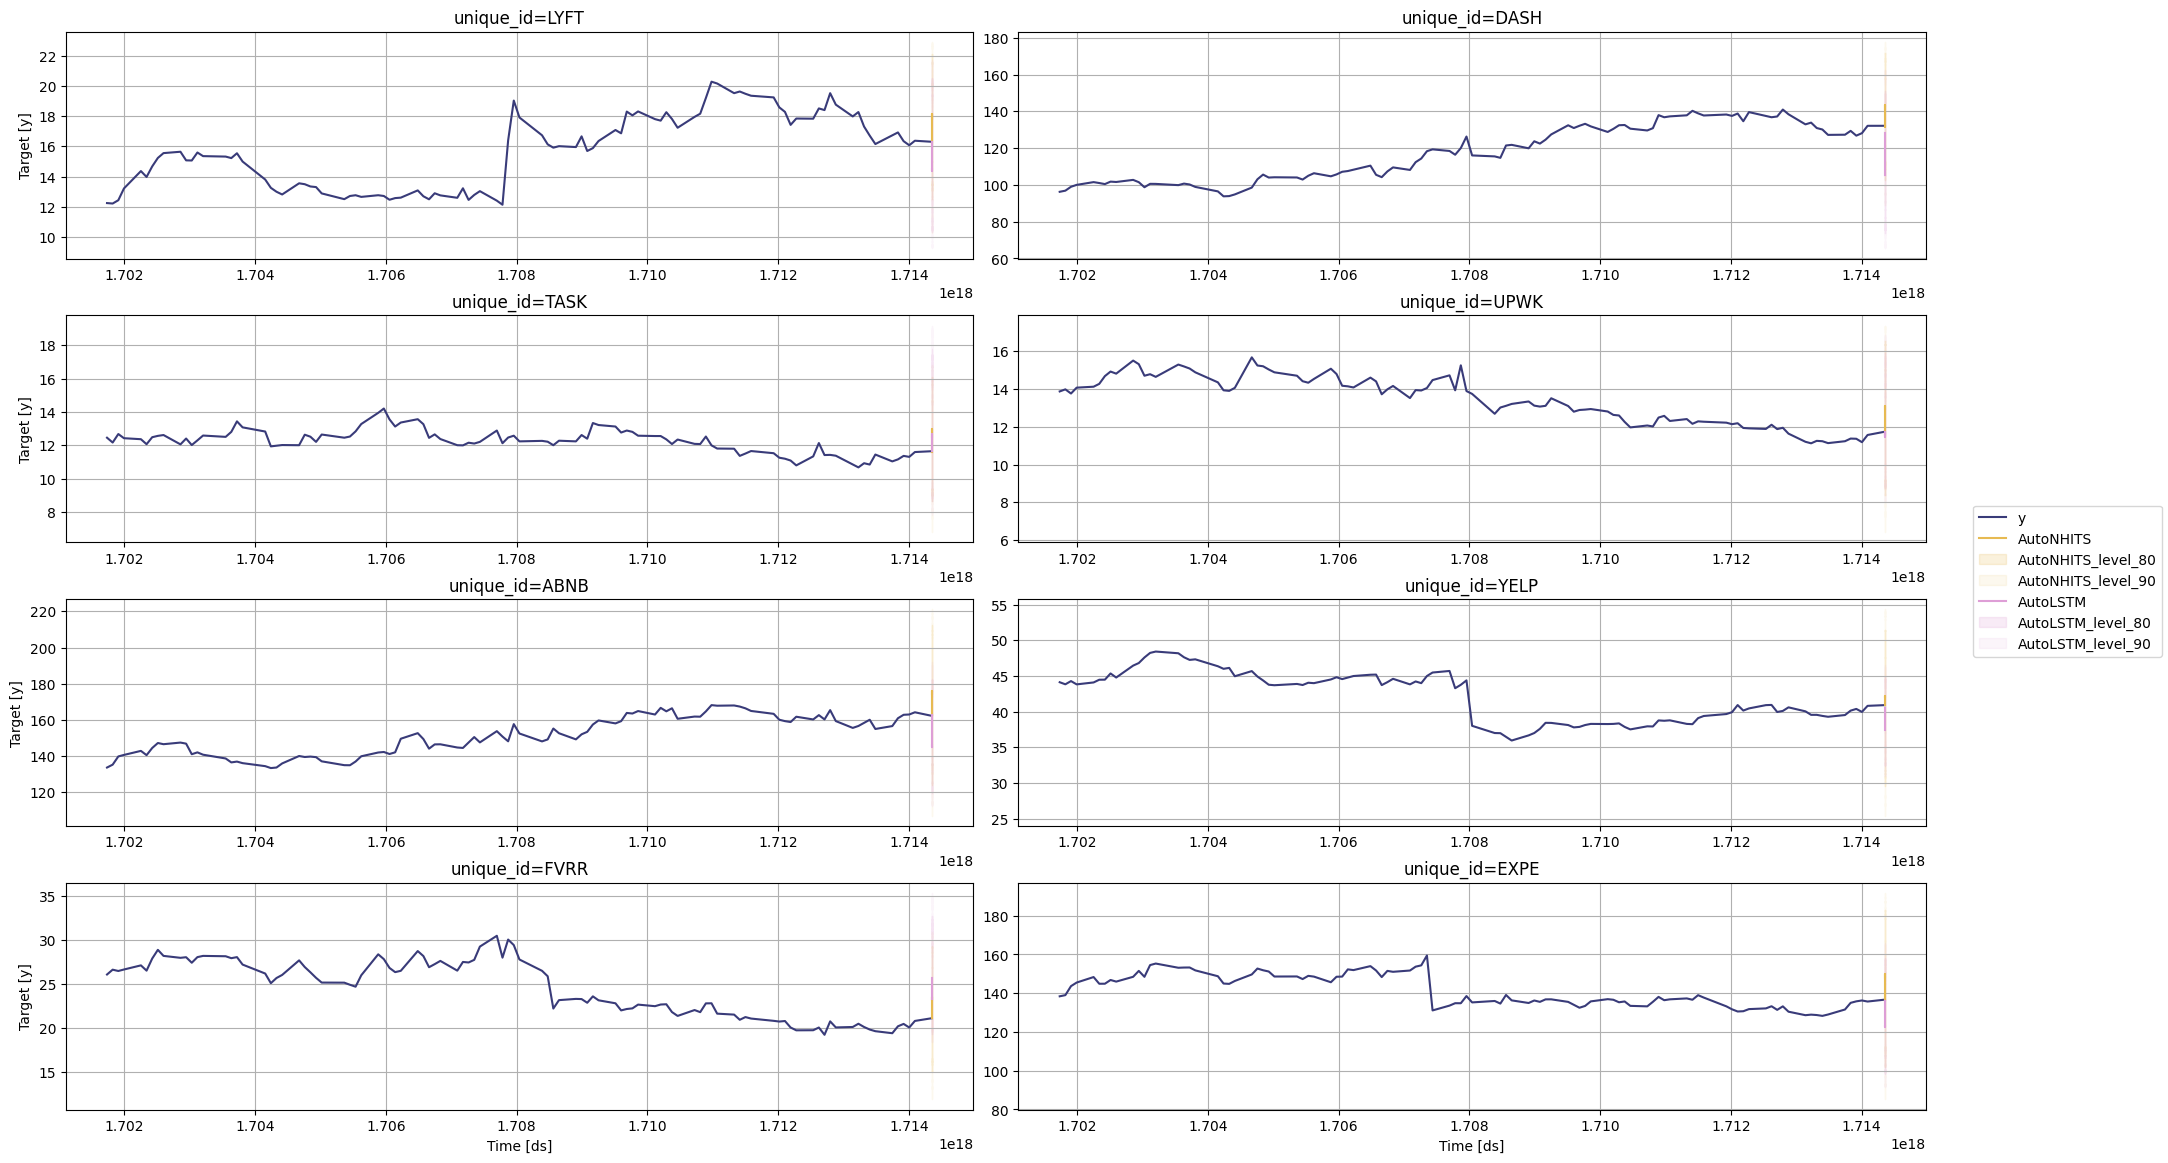

In [ ]:
# visualize predictions
end_date="2024-04-30"
end_date = pd.to_datetime(end_date)

StatsForecast.plot(p2p20, fcst_df, engine='matplotlib', max_insample_length=100, level=[80, 90])

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:1329: FutureWarning:

Passing the ids as the index is deprecated. Please provide them as a column instead.



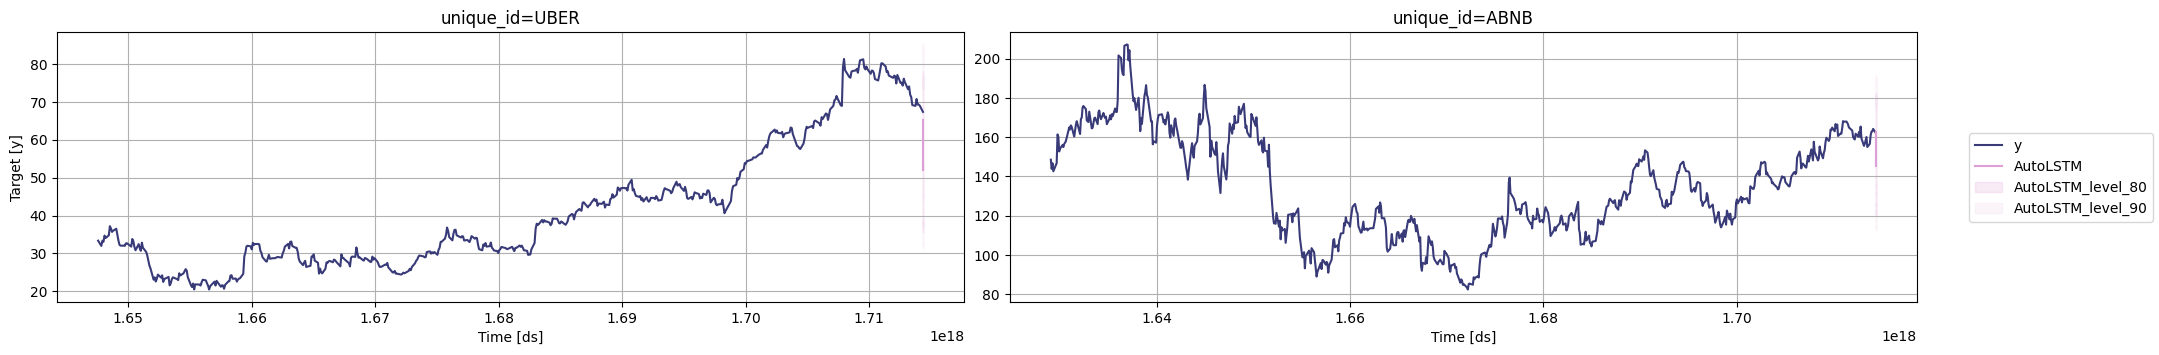

In [ ]:
# Plot LSTM prediction for selected companies
StatsForecast.plot(p2p20, fcst_df, models=["AutoLSTM"], unique_ids=["UBER", "ABNB"], level=[80, 90], engine='matplotlib')


/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:1329: FutureWarning:

Passing the ids as the index is deprecated. Please provide them as a column instead.



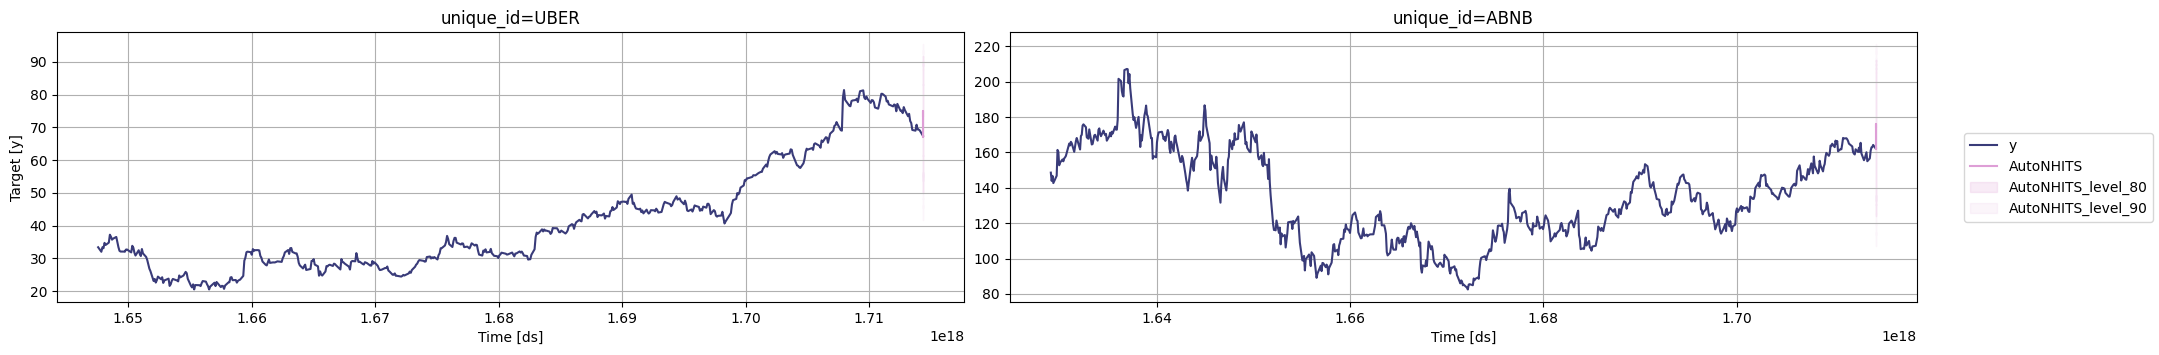

In [ ]:
# Plot N-HITS prediction for selected companies
StatsForecast.plot(p2p20, fcst_df, models=["AutoNHITS"], unique_ids=["UBER", "ABNB"], level=[80, 90], engine='matplotlib')

In [ ]:
# compare performances of N-HITS and LSTM
nf = NeuralForecast(
    models=[
        AutoNHITS(h=48, config=config_nhits, loss=MQLoss(), num_samples=5),
        AutoLSTM(h=48, config=config_lstm, loss=MQLoss(), num_samples=2),
    ],
    freq=1
)

cv_df = nf.cross_validation(p2p20, n_windows=2)
cv_df.columns = cv_df.columns.str.replace('-median', '')
cv_df.head()

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: UserWarning:

Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.



+--------------------------------------------------------------------+
| Configuration for experiment     _train_tune_2024-05-16_15-45-47   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 5                                 |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/_train_tune_2024-05-16_15-45-47
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-05-16_14-54-52_897331_354/artifacts/2024-05-16_15-45-47/_train_tune_2024-05-16_15-45-47/driver_artifacts`


(_train_tune pid=19537) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=19537) Seed set to 3
(_train_tune pid=19537) GPU available: False, used: False
(_train_tune pid=19537) TPU available: False, using: 0 TPU cores
(_train_tune pid=19537) IPU available: False, using: 0 IPUs
(_train_tune pid=19537) HPU available: False, using: 0 HPUs
(_train_tune pid=19537) Missing logger folder: /tmp/ray/session_2024-05-16_14-54-52_897331_354/artifacts/2024-05-16_15-45-47/_train_tune_2024-05-16_15-45-47/working_dirs/_train_tune_b23c7_00000_0_batch_size=1,input_size=96,learning_rate=0.0007,max_steps=1000,n_freq_downsample=1_1_1_1_1,n_pool_kernel_2024-05-16_15-45-47/lightning_logs
(_train_tune pid=19537) 2024-05-16 15:45:58.647867: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261

Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 25.17it/s, v_num=0, train_loss_step=0.592, train_loss_epoch=1.680]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 212.76it/s]
(_train_tune pid=19537) 
Epoch 19: 100%|██████████| 10/10 [00:00<00:00, 18.12it/s, v_num=0, train_loss_step=3.350, train_loss_epoch=1.640, valid_loss=1.130]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  20%|██        | 2/10 [00:00<00:00, 302.98it/s]
(_train_tune pid=19537) 
Validation DataLoader 0:  30%|███       | 3/10 [00:00<00:00, 252.37it/s]
(_train_tune pid=19537) 
Validation DataLoader 0:  40%|████      | 4/10 [00:00<00:00, 200.54it/s]
(_train_tune pid=19537) 
Epoch 29: 100%|██████████| 10/10 [00:00<00:00, 24.50it/s, v_num=0, train_loss_step=0.998, train_loss_epoch=1.620, valid_loss=1.130]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 39: 100%|██████████| 10/10 [00:00<00:00, 14.62it/s, v_num=0, train_loss_step=3.310, tr

(_train_tune pid=19537) `Trainer.fit` stopped: `max_steps=1000` reached.
(_train_tune pid=19865) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=19865) Seed set to 9
(_train_tune pid=19865) GPU available: False, used: False
(_train_tune pid=19865) TPU available: False, using: 0 TPU cores
(_train_tune pid=19865) IPU available: False, using: 0 IPUs
(_train_tune pid=19865) HPU available: False, using: 0 HPUs
(_train_tune pid=19865) Missing logger folder: /tmp/ray/session_2024-05-16_14-54-52_897331_354/artifacts/2024-05-16_15-45-47/_train_tune_2024-05-16_15-45-47/working_dirs/_train_tune_b23c7_00001_1_batch_size=1,input_size=96,learning_rate=0.0098,max_steps=1000,n_freq_downsample=1_1_1_1_1,n_pool_kernel_2024-05-16_15-45-47/lightning_logs
(_train_tune pid=19865) 2024-05-16 15:47:

Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 15.29it/s, v_num=0, train_loss_step=0.627, train_loss_epoch=1.670]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  40%|████      | 4/10 [00:00<00:00, 131.35it/s]
(_train_tune pid=19865) 
Epoch 19: 100%|██████████| 10/10 [00:00<00:00, 23.40it/s, v_num=0, train_loss_step=2.550, train_loss_epoch=1.770, valid_loss=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 29: 100%|██████████| 10/10 [00:00<00:00, 23.42it/s, v_num=0, train_loss_step=0.806, train_loss_epoch=1.670, valid_loss=1.160]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 298.54it/s]
(_train_tune pid=19865) 
Epoch 39: 100%|██████████| 10/10 [00:00<00:00, 16.36it/s, v_num=0, train_loss_step=1.040, train_loss_epoch=1.620, valid_loss=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  50%|█████     | 5/10 [00:00<00:00, 172.57it/s]
(_train_tune pid=19865) 
Epoch 49: 10

(_train_tune pid=19865) `Trainer.fit` stopped: `max_steps=1000` reached.
(_train_tune pid=20186) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=20186) Seed set to 2
(_train_tune pid=20186) GPU available: False, used: False
(_train_tune pid=20186) TPU available: False, using: 0 TPU cores
(_train_tune pid=20186) IPU available: False, using: 0 IPUs
(_train_tune pid=20186) HPU available: False, using: 0 HPUs
(_train_tune pid=20186) Missing logger folder: /tmp/ray/session_2024-05-16_14-54-52_897331_354/artifacts/2024-05-16_15-45-47/_train_tune_2024-05-16_15-45-47/working_dirs/_train_tune_b23c7_00002_2_batch_size=10,input_size=144,learning_rate=0.0005,max_steps=1000,n_freq_downsample=1_1_1_1_1,n_pool_kern_2024-05-16_15-45-47/lightning_logs
(_train_tune pid=20186) 2024-05-16 15:48:

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  5.44it/s, v_num=0, train_loss_step=1.710, train_loss_epoch=1.790]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  5.32it/s, v_num=0, train_loss_step=1.530, train_loss_epoch=1.560, valid_loss=1.160]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  5.32it/s, v_num=0, train_loss_step=1.590, train_loss_epoch=1.600, valid_loss=1.020]
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=20186) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  5.57it/s, v_num=0, train_loss_step=1.440, train_loss_epoch=1.540, valid_loss=1.040]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  6.04it/s, v_num=0, train_loss_step=1.480, train_loss_epoch=1.540, valid_loss=1.070]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 599: 100%|██████████| 1/1 [00:00<00:00,  4.20it/s, v_num=0, train_loss_step=1.400, train_loss_epoch=1.4

(_train_tune pid=20186) `Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s, v_num=0, train_loss_step=1.520, train_loss_epoch=1.180, valid_loss=1.110]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s, v_num=0, train_loss_step=1.520, train_loss_epoch=1.520, valid_loss=1.110]


(_train_tune pid=21171) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=21171) Seed set to 7
(_train_tune pid=21171) GPU available: False, used: False
(_train_tune pid=21171) TPU available: False, using: 0 TPU cores
(_train_tune pid=21171) IPU available: False, using: 0 IPUs
(_train_tune pid=21171) HPU available: False, using: 0 HPUs
(_train_tune pid=21171) Missing logger folder: /tmp/ray/session_2024-05-16_14-54-52_897331_354/artifacts/2024-05-16_15-45-47/_train_tune_2024-05-16_15-45-47/working_dirs/_train_tune_b23c7_00003_3_batch_size=10,input_size=144,learning_rate=0.0017,max_steps=1000,n_freq_downsample=8_4_2_1_1,n_pool_kern_2024-05-16_15-45-47/lightning_logs
(_train_tune pid=21171) 2024-05-16 15:51:52.549416: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s, v_num=0, train_loss_step=1.480, train_loss_epoch=1.550]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  5.44it/s, v_num=0, train_loss_step=1.380, train_loss_epoch=1.380, valid_loss=0.988]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  5.56it/s, v_num=0, train_loss_step=1.250, train_loss_epoch=1.280, valid_loss=1.110]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s, v_num=0, train_loss_step=1.150, train_loss_epoch=1.190, valid_loss=1.120]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, v_num=0, train_loss_step=1.010, train_loss_epoch=1.100, valid_loss=1.160]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 599: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s, v_num=0, train_loss_step=1.020, train_loss_epoch=1.040, valid_loss=1.370]
Val

(_train_tune pid=21171) `Trainer.fit` stopped: `max_steps=1000` reached.
(_train_tune pid=22237) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=22237) Seed set to 14
(_train_tune pid=22237) GPU available: False, used: False
(_train_tune pid=22237) TPU available: False, using: 0 TPU cores
(_train_tune pid=22237) IPU available: False, using: 0 IPUs
(_train_tune pid=22237) HPU available: False, using: 0 HPUs
(_train_tune pid=22237) Missing logger folder: /tmp/ray/session_2024-05-16_14-54-52_897331_354/artifacts/2024-05-16_15-45-47/_train_tune_2024-05-16_15-45-47/working_dirs/_train_tune_b23c7_00004_4_batch_size=1,input_size=96,learning_rate=0.0011,max_steps=1000,n_freq_downsample=1_1_1_1_1,n_pool_kernel_2024-05-16_15-45-47/lightning_logs
(_train_tune pid=22237) 2024-05-16 15:55

Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 23.85it/s, v_num=0, train_loss_step=3.380, train_loss_epoch=1.680]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 10/10 [00:00<00:00, 21.21it/s, v_num=0, train_loss_step=0.681, train_loss_epoch=1.610, valid_loss=1.100]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  10%|█         | 1/10 [00:00<00:00, 299.38it/s]
(_train_tune pid=22237) 
Validation DataLoader 0:  30%|███       | 3/10 [00:00<00:00, 193.60it/s]
(_train_tune pid=22237) 
Validation DataLoader 0:  40%|████      | 4/10 [00:00<00:00, 194.82it/s]
(_train_tune pid=22237) 
Validation DataLoader 0:  50%|█████     | 5/10 [00:00<00:00, 195.05it/s]
(_train_tune pid=22237) 
Validation DataLoader 0:  60%|██████    | 6/10 [00:00<00:00, 196.73it/s]
(_train_tune pid=22237) 
Validation DataLoader 0:  80%|████████  | 8/10 [00:00<00:00, 200.09it/s]
(_train_tune pid=22237) 
Validation DataLoader 0:  90%|█████████ | 9/10 [00:00<00:00, 200.47it/s]
(_

2024-05-16 15:56:52,795	WARNING experiment_state.py:205 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this error by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0).


Epoch 99:  90%|█████████ | 9/10 [00:00<00:00, 21.80it/s, v_num=0, train_loss_step=2.200, train_loss_epoch=1.470, valid_loss=1.290]


2024-05-16 15:56:52,811	INFO tune.py:1007 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/_train_tune_2024-05-16_15-45-47' in 0.0237s.
(_train_tune pid=22237) `Trainer.fit` stopped: `max_steps=1000` reached.
INFO:lightning_fabric.utilities.seed:Seed set to 2
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MQLoss        | 5     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 151 K 
-----------------------------------------------
151 K     Trainable param


Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 22.02it/s, v_num=0, train_loss_step=0.972, train_loss_epoch=1.470, valid_loss=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 20.00it/s, v_num=0, train_loss_step=0.972, train_loss_epoch=1.450, valid_loss=1.330]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

+--------------------------------------------------------------------+
| Configuration for experiment     _train_tune_2024-05-16_16-01-24   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 2                                 |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/_train_tune_2024-05-16_16-01-24
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-05-16_14-54-52_897331_354/artifacts/2024-05-16_16-01-24/_train_tune_2024-05-16_16-01-24/driver_artifacts`


(_train_tune pid=23630) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=23630) Seed set to 12
(_train_tune pid=23630) GPU available: False, used: False
(_train_tune pid=23630) TPU available: False, using: 0 TPU cores
(_train_tune pid=23630) IPU available: False, using: 0 IPUs
(_train_tune pid=23630) HPU available: False, using: 0 HPUs
(_train_tune pid=23630) Missing logger folder: /tmp/ray/session_2024-05-16_14-54-52_897331_354/artifacts/2024-05-16_16-01-24/_train_tune_2024-05-16_16-01-24/working_dirs/_train_tune_b23c0_00000_0_batch_size=1,encoder_hidden_size=64,encoder_n_layers=4,input_size=96,learning_rate=0.0002,max_steps=500,_2024-05-16_16-01-24/lightning_logs
(_train_tune pid=23630) 2024-05-16 16:01:35.019334: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:926

Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 39.11it/s, v_num=0, train_loss_step=0.134, train_loss_epoch=0.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  10%|█         | 1/10 [00:00<00:00, 27.38it/s]
(_train_tune pid=23630) 
Validation DataLoader 0:  40%|████      | 4/10 [00:00<00:00, 21.38it/s]
(_train_tune pid=23630) 
Validation DataLoader 0:  80%|████████  | 8/10 [00:00<00:00, 19.60it/s]
(_train_tune pid=23630) 
Validation DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 19.72it/s]
(_train_tune pid=23630) 
Epoch 19: 100%|██████████| 10/10 [00:00<00:00, 20.66it/s, v_num=0, train_loss_step=0.357, train_loss_epoch=0.309, valid_loss=4.370]
(_train_tune pid=23630) 
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=23630) 
Validation DataLoader 0:   0%|          | 0/10 [00:00<?, ?it/s]
(_train_tune pid=23630) 
Validation DataLoader 0:  10%|█         | 1/10 [00:00<00:00, 13.69it/s]
(_train_tune pid=23630) 
Validation DataLoader 0:  20%|██      

(_train_tune pid=23630) `Trainer.fit` stopped: `max_steps=500` reached.
(_train_tune pid=23825) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=23825) Seed set to 7
(_train_tune pid=23825) GPU available: False, used: False
(_train_tune pid=23825) TPU available: False, using: 0 TPU cores
(_train_tune pid=23825) IPU available: False, using: 0 IPUs
(_train_tune pid=23825) HPU available: False, using: 0 HPUs
(_train_tune pid=23825) Missing logger folder: /tmp/ray/session_2024-05-16_14-54-52_897331_354/artifacts/2024-05-16_16-01-24/_train_tune_2024-05-16_16-01-24/working_dirs/_train_tune_b23c0_00001_1_batch_size=4,encoder_hidden_size=128,encoder_n_layers=4,input_size=144,learning_rate=0.0015,max_steps=10_2024-05-16_16-01-24/lightning_logs
(_train_tune pid=23825) 2024-05-16 16:02:0

Epoch 33:  33%|███▎      | 1/3 [00:00<00:00,  7.91it/s, v_num=0, train_loss_step=0.214, train_loss_epoch=0.488]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/3 [00:00<?, ?it/s]
(_train_tune pid=23825) 
Validation DataLoader 0:  33%|███▎      | 1/3 [00:00<00:00,  2.79it/s]
(_train_tune pid=23825) 
Validation DataLoader 0:  67%|██████▋   | 2/3 [00:00<00:00,  3.24it/s]
(_train_tune pid=23825) 
Epoch 66:  67%|██████▋   | 2/3 [00:00<00:00,  7.93it/s, v_num=0, train_loss_step=0.210, train_loss_epoch=0.227, valid_loss=4.450]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/3 [00:00<?, ?it/s]
(_train_tune pid=23825) 
Validation DataLoader 0:  33%|███▎      | 1/3 [00:00<00:00,  3.37it/s]
(_train_tune pid=23825) 
Validation DataLoader 0:  67%|██████▋   | 2/3 [00:00<00:00,  3.63it/s]
(_train_tune pid=23825) 
Epoch 99: 100%|██████████| 3/3 [00:00<00:00,  9.44it/s, v_num=0, train_loss_step=0.159, train_loss_epoch=0

(_train_tune pid=23825) `Trainer.fit` stopped: `max_steps=1000` reached.
2024-05-16 16:04:30,367	WARNING experiment_state.py:205 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this error by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0).
2024-05-16 16:04:30,373	INFO tune.py:1007 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/_train_tune_2024-05-16_16-01-24' in 0.0114s.
INFO:lightning_fabric.utilities.seed:Seed set to 7


(_train_tune pid=23825) 
Validation DataLoader 0:  67%|██████▋   | 2/3 [00:00<00:00,  3.69it/s]
(_train_tune pid=23825) 
Epoch 333:  33%|███▎      | 1/3 [00:00<00:01,  1.14it/s, v_num=0, train_loss_step=0.130, train_loss_epoch=0.130, valid_loss=1.610]



INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type          | Params
--------------------------------------------------
0 | loss            | MQLoss        | 5     
1 | padder          | ConstantPad1d | 0     
2 | scaler          | TemporalNorm  | 0     
3 | hist_encoder    | LSTM          | 463 K 
4 | context_adapter | Linear        | 61.9 K
5 | mlp_decoder     | MLP           | 3.2 K 
--------------------------------------------------
528 K     Trainable params
5         Non-trainable params
528 K     Total params
2.114     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:196: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.



,ds,cutoff,AutoNHITS,AutoNHITS-lo-90,AutoNHITS-lo-80,AutoNHITS-hi-80,AutoNHITS-hi-90,AutoLSTM,AutoLSTM-lo-90,AutoLSTM-lo-80,AutoLSTM-hi-80,AutoLSTM-hi-90,y
unique_id,,,,,,,,,,,,,
ABNB,1708387200000000000,1708041600000000000,152.151611,145.443436,147.034149,157.720047,158.947006,162.538300,143.089081,149.382584,177.035355,184.965881,148.149994
ABNB,1708473600000000000,1708041600000000000,152.100266,140.364395,144.829315,159.931915,162.048019,163.766830,143.589005,149.697205,179.365952,187.583496,149.240005
ABNB,1708560000000000000,1708041600000000000,151.937073,138.604965,142.903534,162.147446,165.572449,160.789230,141.283493,148.380432,174.849060,183.518066,155.259995
ABNB,1708646400000000000,1708041600000000000,151.745300,135.430161,141.628418,161.953033,165.664597,161.364929,139.970673,146.966873,176.353394,184.956451,152.660004
ABNB,1708905600000000000,1708041600000000000,153.139221,132.909744,138.404556,162.599731,167.054840,161.210220,139.685760,146.270584,176.216278,185.394119,149.270004


In [ ]:
for cutoff in cv_df['cutoff'].unique():
    StatsForecast.plot(
        p2p20,
        cv_df.query('cutoff == @cutoff').drop(columns=['y', 'cutoff']),
        max_insample_length=48 * 4,
        unique_ids=['H185'],
        engine='matplotlib'
    )

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:1329: FutureWarning:

Passing the ids as the index is deprecated. Please provide them as a column instead.

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:1329: FutureWarning:

Passing the ids as the index is deprecated. Please provide them as a column instead.



In [ ]:
from datasetsforecast.losses import mse, mae, rmse
from datasetsforecast.evaluation import accuracy
cv_df = cv_df.reset_index()
Y_df = p2p20.reset_index()

In [ ]:
evaluation_df = accuracy(cv_df, [mse, mae, rmse], agg_by=['unique_id'])

evaluation_df['best_model'] = evaluation_df.drop(columns=['metric', 'unique_id']).idxmin(axis=1)
evaluation_df.head()

,metric,unique_id,AutoNHITS,AutoLSTM,best_model
0,mae,ABNB,17.233277,14.259003,AutoLSTM
1,mae,DASH,16.772314,22.340231,AutoNHITS
2,mae,EXPE,2.513005,5.218459,AutoNHITS
3,mae,FVRR,4.734767,5.386102,AutoNHITS
4,mae,LYFT,1.147890,2.171432,AutoNHITS


In [ ]:
summary_df = evaluation_df.groupby(['metric', 'best_model']).size().sort_values().to_frame()

summary_df = summary_df.reset_index()
summary_df.columns = ['metric', 'model', 'nr. of unique_ids']
summary_df

,metric,model,nr. of unique_ids
0,mae,AutoLSTM,3
1,mse,AutoLSTM,3
2,rmse,AutoLSTM,3
3,mae,AutoNHITS,7
4,mse,AutoNHITS,7
5,rmse,AutoNHITS,7


In [ ]:
summary_df.query('metric == "mse"')

,metric,model,nr. of unique_ids
1,mse,AutoLSTM,3
4,mse,AutoNHITS,7


/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:1329: FutureWarning:

Passing the ids as the index is deprecated. Please provide them as a column instead.



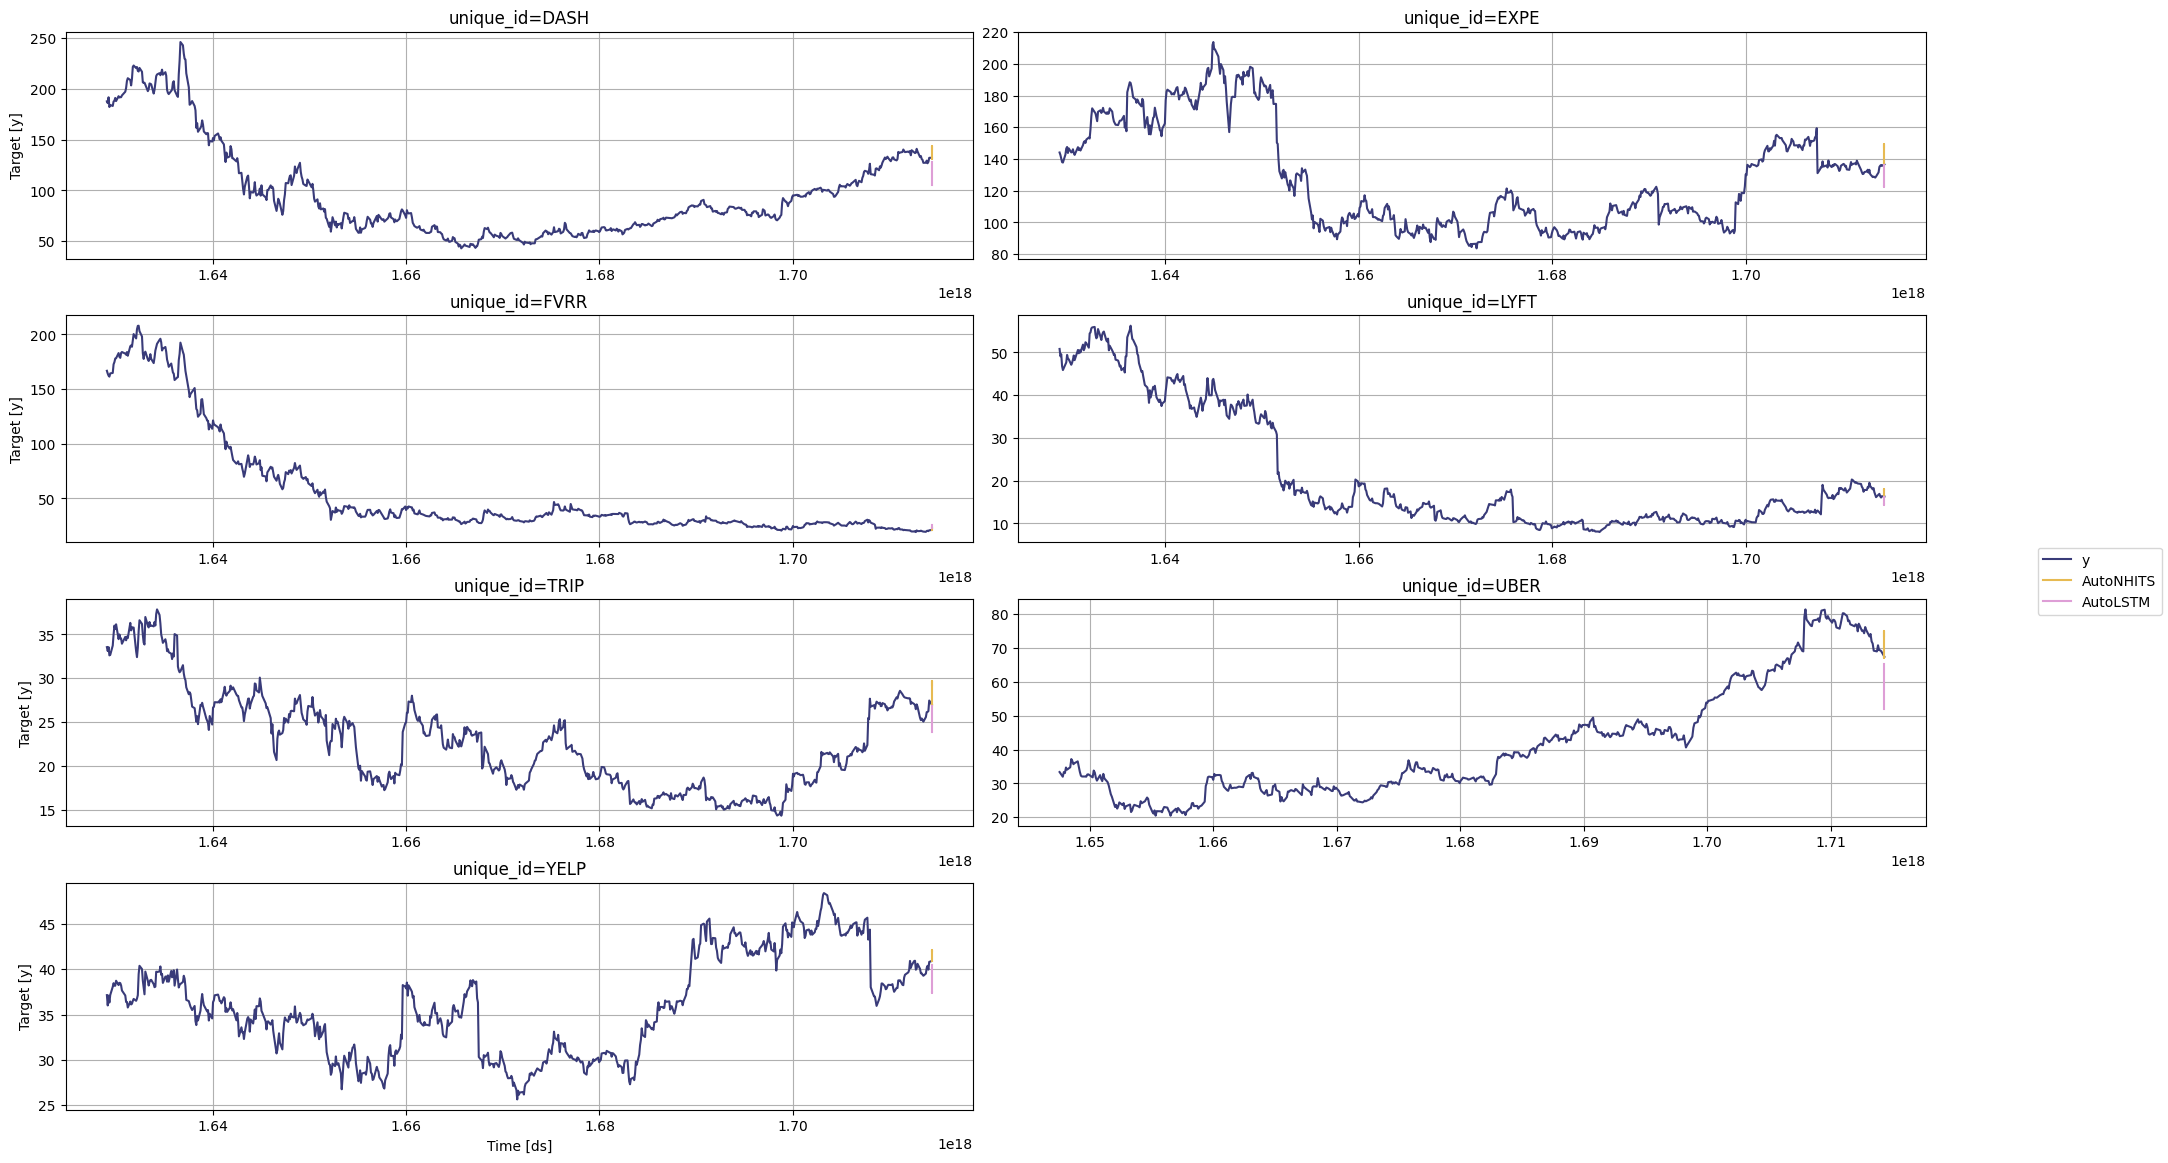

In [ ]:
nhits_ids = evaluation_df.query('best_model == "AutoNHITS" and metric == "mse"')['unique_id'].unique()

StatsForecast.plot(Y_df, fcst_df, unique_ids=nhits_ids, engine='matplotlib')

In [ ]:
# select best model for each unique series
def get_best_model_forecast(forecasts_df, evaluation_df, metric):
    df = forecasts_df.set_index('ds', append=True).stack().to_frame().reset_index(level=2) # Wide to long
    df.columns = ['model', 'best_model_forecast']
    df = df.join(evaluation_df.query('metric == @metric').set_index('unique_id')[['best_model']])
    df = df.query('model.str.replace("-lo-90|-hi-90", "", regex=True) == best_model').copy()
    df.loc[:, 'model'] = [model.replace(bm, 'best_model') for model, bm in zip(df['model'], df['best_model'])]
    df = df.drop(columns='best_model').set_index('model', append=True).unstack()
    df.columns = df.columns.droplevel()
    df = df.reset_index(level=1)
    return df

prod_forecasts_df = get_best_model_forecast(fcst_df, evaluation_df, metric='mse')
prod_forecasts_df.head()

model,ds,best_model,best_model-hi-90,best_model-lo-90
unique_id,,,,
ABNB,1714348800000000001,162.519852,180.779099,145.334625
ABNB,1714348800000000002,162.470947,181.021973,144.176910
ABNB,1714348800000000003,161.907654,183.625961,140.987564
ABNB,1714348800000000004,161.701126,186.240753,136.974228
ABNB,1714348800000000005,161.105804,182.066467,139.372070


/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:1329: FutureWarning:

Passing the ids as the index is deprecated. Please provide them as a column instead.



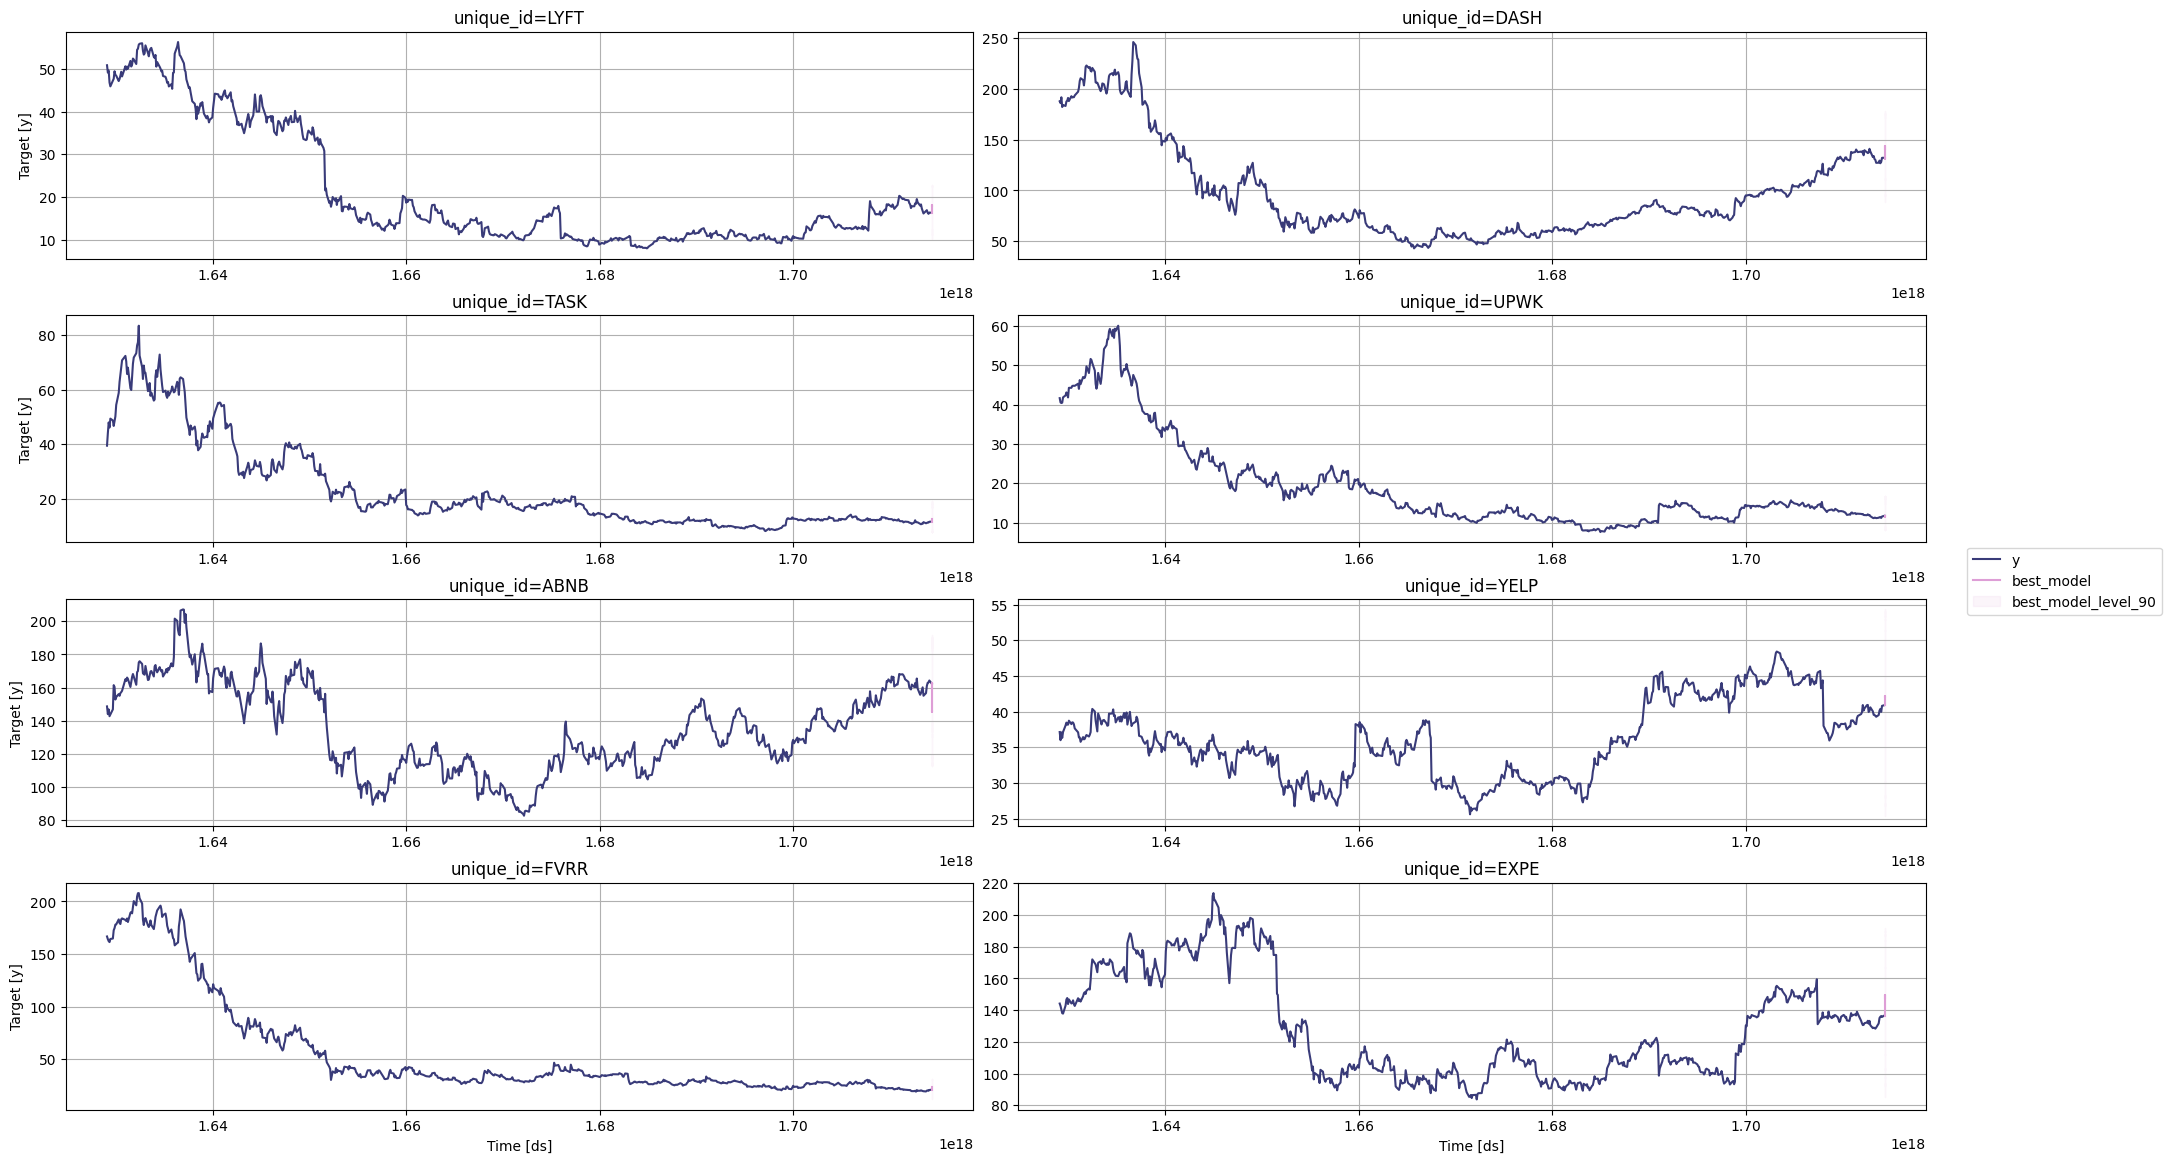

In [ ]:
StatsForecast.plot(Y_df, prod_forecasts_df, level=[90], engine='matplotlib')

#### This limited prediction is maybe coming from the need to receive a token from neuralink timeGPT.